# COVID-19 in Australia and Taiwan

## A country comparison

During the ABC's popular "Q and A" on Monday 23 March, it was highlighted by the panelists that Taiwan is doing a much better job than Australia in controlling the spread of COVID-19, despite the almost identical population sizes and Taiwan's higher exposure to visitors to mainland China. This analysis will further investigate this claim and the potential reasons put forward. 

Suggested reasons include:

 - Taiwan's readiness after being scarred by the SARS crisis in 2003
 - Temperature screening of all international visitors at airports, even prior to the COVID-19 outbreak
 - A significantly higher willingness to use data as a tool to track and contain the disease, such as data matching airport arrivals, GP visits and health insurance

In [1]:
# wrangling tools
import numpy as np
import pandas as pd
import datetime as dt
# viz tools
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [3]:
#import sys
#!{sys.executable} -m pip install plotnine

In [10]:
df_c19_all = pd.read_csv('covid_19_data.csv')
df_c19_all.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [11]:
# initial cleaning

df_c19_all['ObservationDate'] = pd.to_datetime(df_c19_all['ObservationDate'])
df_c19_all.rename(columns={'Country/Region':'Country'}, inplace=True)

This data provides granularity down to the province level, which is useful when looking at countries like China and US. For now though, we are interested in the total confirmed cases per day per country, so we aggregate.

This analysis will do an comparison of two countries: Australia and Taiwan. We create dataframes for both countries separately, and also merge to make one dataframe for comparison

Firstly, let's investigate the theory that Australia and Taiwan have had very different rates of increase in confirmed cases of COVID-19 over since late January 2020.

In [12]:
def filter_country_group(df, country1, country2):
    
    df_filtered = df[(df['Country'] == country1) | 
          (df['Country'] == country2)]
    df_filtered = df_filtered[['ObservationDate',
                      'Country',
                      'Confirmed',
                      'Deaths',
                      'Recovered']].groupby(['Country', 'ObservationDate']).sum().reset_index()
    df_filtered.sort_values('ObservationDate', inplace=True)
    df_filtered.reset_index(drop=True, inplace=True)
    
    return(df_filtered)

In [14]:
df_au_tw = filter_country_group(df_c19_all, "Australia", "Taiwan")
df_au_tw.tail()

,Country,ObservationDate,Confirmed,Deaths,Recovered
127,Taiwan,2020-03-26,252.0,2.0,29.0
128,Taiwan,2020-03-27,267.0,2.0,29.0
129,Australia,2020-03-27,3143.0,13.0,194.0
130,Australia,2020-03-28,3640.0,14.0,244.0
131,Taiwan,2020-03-28,283.0,2.0,30.0


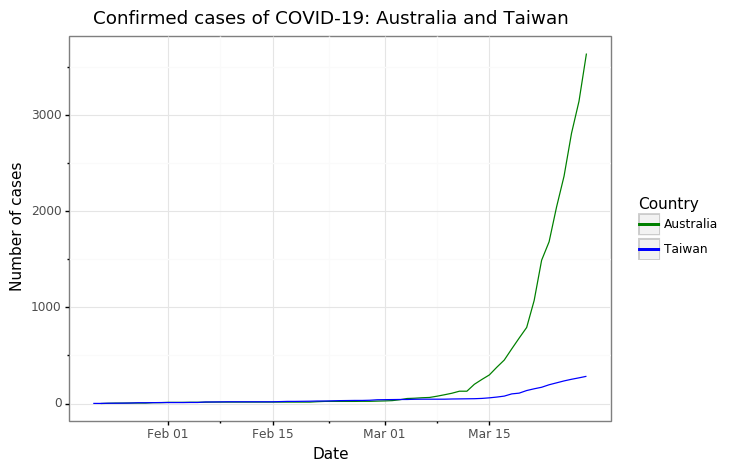

<ggplot: (7551103033)>

In [15]:
(p9.ggplot(df_au_tw)
 + p9.geoms.geom_line(p9.aes('ObservationDate', 'Confirmed', colour='Country'))
 + p9.scales.scale_colour_manual(values = ("green", "blue"))
 + p9.themes.theme_bw()
 + p9.theme(figure_size=(7,5))
 + p9.scales.scale_x_date(labels = date_format('%b %d'))
 + p9.labels.labs(title = "Confirmed cases of COVID-19: Australia and Taiwan",
                 x = "Date",
                 y = 'Number of cases')
)

It appears the growth rates in confirmed cases for the two countries remained very similar until early March. Lets investigate exactly where growth rates began to differ significantly.

In [19]:
def pivot_pct_change(df):
    
    df_pivot = df.pivot('ObservationDate', 'Country', 'Confirmed').reset_index()
    df_pivot = df_pivot.fillna(0)
    
    df_pivot[['aus_pct_change', 'tw_pct_change']] = df_pivot[['Australia', 'Taiwan']].pct_change()
    df_pivot.fillna(0, inplace=True)
    
    
    df_melted = df_pivot[['ObservationDate', 'aus_pct_change', 'tw_pct_change']].melt('ObservationDate',
                                                                                      var_name='Country',
                                                                                      value_name='pct_change').sort_values(['ObservationDate', 'Country'])
    countries = {'aus_pct_change':'Australia',
               'tw_pct_change': 'Taiwan'}
    df_melted['Country'] = df_melted['Country'].map(countries)
    df_melted.reset_index(inplace = True, drop=True)
    
    return(df_melted)

In [20]:
au_tw_pctchange = pivot_pct_change(df_au_tw)
au_tw_pctchange

,ObservationDate,Country,pct_change
0,2020-01-22,Australia,0.000000
1,2020-01-22,Taiwan,0.000000
2,2020-01-23,Australia,0.000000
3,2020-01-23,Taiwan,0.000000
4,2020-01-24,Australia,0.000000
...,...,...,...
129,2020-03-26,Taiwan,0.072340
130,2020-03-27,Australia,0.118505
131,2020-03-27,Taiwan,0.059524
132,2020-03-28,Australia,0.158129


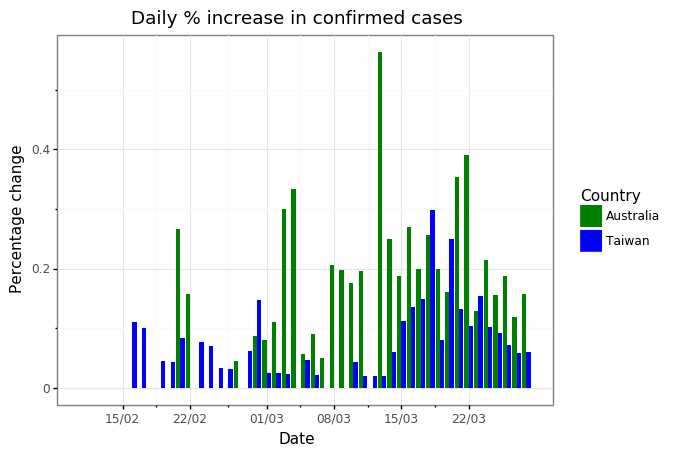

<ggplot: (7551131621)>

In [21]:
(p9.ggplot(au_tw_pctchange[au_tw_pctchange['ObservationDate'] > '2020-02-10'], 
           p9.aes('ObservationDate', 'pct_change', 
                      fill='Country'))
 + p9.geoms.geom_col(stat='identity', position='dodge')
 + p9.scales.scale_fill_manual(values = ("green", "blue"))
 + p9.themes.theme_bw()
 + p9.scales.scale_x_date(labels = date_format('%d/%m'))
 + p9.labels.labs(title = "Daily % increase in confirmed cases",
                 y = "Percentage change",
                 x = "Date")
)

It is clear from the above that Australia has had a much higher daily percentage increase in confirmed cases since mid February.

At what point did first deaths occur?

In [317]:
def print_first_date(df, country, metric):
   
    country_df = df[df['Country'] == country]
    
    var = country_df[country_df[metric] >= 1.0].sort_values('ObservationDate').head(1)['ObservationDate']
    var = np.datetime_as_string(var.values[0])[:10]
    
    print(var)

In [318]:
countries = ['Australia', 'Taiwan']
metric = ['Confirmed', 'Deaths']

for c in countries:
    for m in metric:
        print('The first {} '.format(m)+ 'in {} occurred on:'.format(c)) 
        print_first_date(df_au_tw, c, m)

The first Confirmed in Australia occurred on:
2020-01-25
The first Deaths in Australia occurred on:
2020-03-01
The first Confirmed in Taiwan occurred on:
2020-01-22
The first Deaths in Taiwan occurred on:
2020-02-16


In [319]:
df_c19_all[df_c19_all['Country'] == "Taiwan"]

,SNo,ObservationDate,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
28,29,2020-01-22,Taiwan,Taiwan,1/22/2020 17:00,1.0,0.0,0.0
66,67,2020-01-23,Taiwan,Taiwan,1/23/20 17:00,1.0,0.0,0.0
107,108,2020-01-24,Taiwan,Taiwan,1/24/20 17:00,3.0,0.0,0.0
154,155,2020-01-25,Taiwan,Taiwan,1/25/20 17:00,3.0,0.0,0.0
199,200,2020-01-26,Taiwan,Taiwan,1/26/20 16:00,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7118,7119,2020-03-20,NaN,Taiwan,2020-03-20T09:43:03,135.0,2.0,26.0
7421,7422,2020-03-21,NaN,Taiwan,2020-03-21T07:43:02,153.0,2.0,28.0
7761,7762,2020-03-22,NaN,Taiwan,3/8/20 5:31,169.0,2.0,28.0
8059,8060,2020-03-23,NaN,Taiwan,2020-03-23 23:23:20,195.0,2.0,28.0


In [320]:
df_cov19_detail = pd.read_csv('COVID19_open_line_list.csv')
df_cov19_detail.dropna(axis='columns', how='all', inplace=True)
df_cov19_detail.dropna(how='all', inplace=True)
df_cov19_detail

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,Baohe District,Hefei City,Anhui,China,340111,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,Feidong County,Hefei City,Anhui,China,340122,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,13475.0,60-69,male,Nagoya City,Aichi Prefecture,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13170,13476.0,40-49,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13171,13477.0,0-10,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13172,13478.0,NaN,female,Amsterdam,NaN,Netherlands,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
df_cov19_detail[df_cov19_detail['country'] == "Australia"].columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country',
       'wuhan(0)_not_wuhan(1)', 'latitude', 'longitude', 'geo_resolution',
       'date_onset_symptoms', 'date_admission_hospital', 'date_confirmation',
       'symptoms', 'lives_in_Wuhan', 'travel_history_dates',
       'travel_history_location', 'reported_market_exposure',
       'additional_information', 'chronic_disease_binary', 'chronic_disease',
       'source', 'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials'],
      dtype='object')

In [305]:
# what are the most common symptoms?

symptoms = df_cov19_detail['symptoms'].dropna()
print(symptoms.value_counts())

fever                                    131
cough, fever                              55
pneumonitis                               19
cough                                     15
pneumonia                                  7
                                        ... 
systemic weakness, runny nose, fever       1
fever; runny nose                          1
Fever (37.4 ° C), malaise, sore throa      1
cough; fever                               1
discomfort, fever                          1
Name: symptoms, Length: 217, dtype: int64
